# 🧠 Spam Classification Using GPT-2 Transformer (with `tiktoken` Tokenizer)

This project demonstrates the fine-tuning of a **GPT-2-based transformer** model for binary classification — identifying whether an input SMS message is **spam** or **not spam**.

---

## 🎯 Objective

Train a lightweight transformer model (GPT-2 Small - 124M) to classify text messages as:
- 📩 **Ham** – legitimate, personal, or informative messages  
- 🚫 **Spam** – unsolicited promotional or fraudulent content

---

## 📂 Dataset

The dataset is based on the classic **SMS Spam Collection**, which has been:
- Preprocessed and cleaned
- Balanced to ensure equal representation of `spam` and `ham` messages

---

## 🛠️ Tools & Technologies

- **Model**: GPT-2 Small (124M parameters)
- **Tokenizer**: [`tiktoken`](https://github.com/openai/tiktoken) — optimized BPE tokenizer from OpenAI  
- **Framework**: PyTorch
- **Training & Evaluation**: Custom loaders, loss/accuracy evaluation, partial layer unfreezing
- **Visualization**: Matplotlib for plotting training curves

---

## 🔄 Workflow Summary

1. **Preprocessing**
   - Label encoding: `"spam" → 1`, `"ham" → 0`
   - Tokenization using `tiktoken`, padding/truncation to fit GPT context (≤1024 tokens)

2. **Model Customization**
   - Load GPT-2 architecture from scratch
   - Freeze all but the final transformer block and output head
   - Replace the original `out_head` to classify into 2 classes

3. **Training**
   - Fine-tune with CrossEntropyLoss
   - Evaluate periodically on a validation split
   - Use `AdamW` optimizer with weight decay

4. **Evaluation**
   - Compute accuracy and loss on:
     - Training set
     - Validation set
     - Test set

5. **Visualization**
   - Line plots for training/validation loss and accuracy

6. **Inference**
   - Classify custom messages using the fine-tuned model

---

## 📊 Performance Snapshot

| Dataset    | Accuracy (%) | Loss   |
|------------|--------------|--------|
| Training   | 98.75%       | 0.772  |
| Validation | 95.97%       | 0.764  |
| Test       | 94.00%       | 0.789  |

> ⚠️ The results indicate strong performance, with the model generalizing well even with limited fine-tuning.

---

## 🔍 Sample Predictions

```python
text = "Congratulations! You've been selected for a free cruise to the Bahamas."
print(classify_review(text, model, tokenizer, device))  # ➜ spam

text = "Hey, are we still on for the meeting at 3 PM?"
print(classify_review(text, model, tokenizer, device))  # ➜ not spam
```

---

## ✅ Conclusion

By leveraging the capabilities of GPT-2 and the efficiency of `tiktoken`, we achieved high accuracy on a binary classification task using minimal labeled data and only partial model fine-tuning. This approach can be adapted to similar tasks like phishing detection, toxic comment filtering, or support ticket triage.

---


In [70]:
import torch
import torch.nn as nn

In [181]:
# Model configuration dictionary (124M parameter version)
GPT_CONFIG_124m={
    'vocab_size':50257,        # Size of the vocabulary; used in the embedding layer
    'context_length':256,     # Maximum number of tokens the model can consider at once (sequence length)
    'emb_dim':768,             # Dimensionality of the token embeddings and hidden states
    'n_heads':12,              # Number of attention heads in the multi-head attention mechanism
    'n_layers':12,             # Number of transformer blocks/layers in the model
    'dropout':0.1,             # Dropout rate used during training to prevent overfitting
    'qkv_bias':False           # Whether to use bias terms in the query, key, and value projection layers
}

### IMPLEMENTING MULTI-HEAD ATTENTION WITH WEIGHT SPLITS


This implementation of `MultiHeadAttention` efficiently computes multi-head self-attention by splitting and processing attention heads in parallel within a single module.

---

#### Key Highlights:

- **Query, Key, Value Projections**: The input tensor is projected using three separate linear layers to obtain queries, keys, and values.
- **Head Splitting with Reshape and Transpose**: The output dimension (`d_out`) is divided into `num_heads` and `head_dim`, enabling parallel attention processing across multiple heads.
- **Causal Masking**: A causal mask is applied to ensure that each position can only attend to previous and current positions in the sequence.
- **Output Projection**: After computing attention for each head and combining the results, a final linear layer projects the output back to the original embedding size.

---

#### Step-by-Step Breakdown:

1. **Linear Projections**: The input is linearly transformed into queries, keys, and values of shape `(b, num_tokens, d_out)`.
2. **Head Reshaping**: These are reshaped to `(b, num_tokens, num_heads, head_dim)` using `.view()`.
3. **Transposition**: The tensors are transposed to `(b, num_heads, num_tokens, head_dim)` to align for batched matrix multiplication.
4. **Attention Scores**: Attention scores are computed using the scaled dot product: `queries @ keys.T`, scaled by `sqrt(head_dim)`.
5. **Masking**: A causal mask is applied to the upper triangular part to block future tokens.
6. **Softmax and Dropout**: The masked attention scores are passed through softmax and dropout for regularization.
7. **Context Vector**: Attention weights are used to compute a weighted sum of values, producing the context vector.
8. **Combining Heads**: The heads are transposed back and reshaped into a single tensor of shape `(b, num_tokens, d_out)`.
9. **Output Projection**: The final context vector is passed through an output linear layer (`self.out_proj`).

---

This structure enables efficient multi-head attention using batched operations and avoids redundant computation, making it well-suited for large-scale Transformer models.


In [182]:
#Implementing scaled dot-product attention with masking
class MultiHeadAttention(nn.Module):
  def __init__(self,d_in,d_out,context_length,dropout,num_heads,qkv_bias=False):
    # Just making sure the output size works with how many heads we want
    # Ensure the output dimension is divisible by the number of heads
    super().__init__()
    assert (d_out%num_heads==0),'d_out must be divisible by num_heads'

    self.d_out=d_out
    self.num_heads=num_heads
    self.head_dim=d_out//num_heads              # Each head gets a slice of the total embedding

    # Linear layers to get Q, K, V
    self.W_query=nn.Linear(d_in,d_out,bias=qkv_bias)
    self.W_key=nn.Linear(d_in,d_out,bias=qkv_bias)
    self.W_value=nn.Linear(d_in,d_out,bias=qkv_bias)
    self.out_proj=nn.Linear(d_out,d_out)        # this layer use to combine head outputs
    self.dropout=nn.Dropout(dropout)            # Dropout layer to prevent overfitting
    # Causal mask to prevent attention to future tokens
    self.register_buffer('mask',torch.triu(torch.ones(context_length,context_length),diagonal=1))

  def forward(self,x):
    b,num_tokens,d_in=x.shape                  # b: batch size, num_tokens: sequence length
    # Linear projections
    queries=self.W_query(x)
    keys=self.W_key(x)                         # Shape: (b, num_tokens, d_out)
    values=self.W_value(x)

    # Break each into multiple heads for parallel attention
    #implicitly split the matrix by adding a `num_heads` dimension
    # Unroll last dim: (b, num_tokens, d_out) to (b, num_tokens, num_heads, head_dim)
    keys=keys.view(b,num_tokens,self.num_heads,self.head_dim)
    queries=queries.view(b,num_tokens,self.num_heads,self.head_dim)
    values=values.view(b,num_tokens,self.num_heads,self.head_dim) # Changed self.head to self.head_dim

    #transpose: (b,num_tokens,num_heads,head_dim) to (b,num_heads,num_tokens,head_dim)
    keys=keys.transpose(1,2)
    queries=queries.transpose(1,2)
    values=values.transpose(1,2)

    #Dot prod of each head
    # Compute scaled dot-product attention(self-attention) with a causal mask
    attn_scores=queries @ keys.transpose(2,3)       # Shape: (b, heads, seq_len, seq_len)

    # Original mask truncated to the number of tokens and converted to boolean
    #####mask_bool=self.mask.bool()[:num_tokens,:num_tokens]
    mask_bool = self.mask[:num_tokens, :num_tokens].bool().to(x.device)
    # Use the mask to fill attention scores
    attn_scores.masked_fill_(mask_bool,-torch.inf)
    ######attn_scores.masked_fill_(mask_bool, -1e9)

    attn_weights=torch.softmax(attn_scores/keys.shape[-1]**0.5,dim=-1)
    attn_weights=self.dropout(attn_weights)

    # Shape: (b, num_tokens, num_heads, head_dim)
    context_vec=(attn_weights @values).transpose(1,2)

    # Combine heads, where self.d_out = self.num_heads * self.head_dim
    context_vec=context_vec.contiguous().view(b,num_tokens,self.d_out) # contiguous is used for reshape matrices in same block of memory
    context_vec=self.out_proj(context_vec)
    return context_vec

### Custom Layer Normalization with Learnable Parameters

This is a custom implementation of Layer Normalization, which normalizes the input across the last dimension (usually the embedding dimension) and includes two trainable parameters: **scale (γ)** and **shift (β)**.

---

#### Key Components:

- **Mean and Variance Computation**:
  - Mean and variance are computed across the last dimension for each input tensor.
  - `unbiased=False` is used to divide by `n` instead of `n-1` (Bessel’s correction is avoided for efficiency).

- **Normalization Formula**:
  $$
  \text{norm}_x = \frac{x - \mu}{\sqrt{\sigma^2 + \epsilon}}
  $$

- **Learnable Parameters**:
  - `scale (γ)`: Initialized as ones, used to scale the normalized output.
  - `shift (β)`: Initialized as zeros, used to shift the normalized output.

- **Epsilon (ε)**:
  - A small constant (`1e-5`) added to the variance to prevent division by zero.

---

#### Forward Pass Steps:

1. Compute the **mean** and **variance** along the last dimension.
2. Normalize the input: subtract the mean and divide by the standard deviation.
3. Apply learnable **scale** and **shift** parameters.
4. Return the final normalized and parameter-adjusted output.

---

This layer helps stabilize training by ensuring consistent input distributions throughout the network, especially beneficial in deep Transformer architectures.


In [183]:
#Implementing Custom layer normalization with learnable parameters
class LayerNorm(nn.Module):
  def __init__(self,emb_dim):
    super().__init__()
    self.eps=1e-5
    self.scale=nn.Parameter(torch.ones(emb_dim))          # Learnable scale parameter (γ)
    self.shift=nn.Parameter(torch.zeros(emb_dim))         # Learnable shift parameter (β)

  def forward(self,x):
    mean=x.mean(dim=-1,keepdim=True)                      # Compute mean along the last dimension
    var=x.var(dim=-1,keepdim=True,unbiased=False)         # unbiased is false bcz of to divide by n instead of n-1(bessels correction)
    norm_x=(x-mean)/torch.sqrt(var+self.eps)              # Normalize input
    return self.scale* norm_x + self.shift                # Apply learnable scale and shift

### Custom Implementation of the GELU Activation Function

This is a custom PyTorch implementation of the **Gaussian Error Linear Unit (GELU)** activation, commonly used in Transformer models such as BERT and GPT.

---

#### What is GELU?

GELU is a smooth and differentiable activation function that combines properties of both ReLU and sigmoid functions. Instead of abruptly cutting off values like ReLU, GELU weights inputs based on their magnitude.

---

#### Approximation Formula:

The original GELU function is defined using the Gaussian cumulative distribution function. However, for efficiency, a commonly used tanh-based approximation is:

$$
\text{GELU}(x) = 0.5 \cdot x \cdot \left(1 + \tanh\left[\sqrt{\frac{2}{\pi}} \cdot \left(x + 0.044715 \cdot x^3\right)\right]\right)
$$

---

#### Forward Pass:

1. Compute the cubic term: \( 0.044715 \cdot x^3 \)
2. Add it to the input: \( x + 0.044715 \cdot x^3 \)
3. Multiply by \( \sqrt{2/\pi} \) and apply `tanh`
4. Multiply the result by \( 0.5 \cdot x \)

This provides a smooth, non-linear activation that performs well in practice, especially in NLP models.

---

#### Why Use GELU?

- It allows small negative values to pass (unlike ReLU)
- Leads to better gradient flow
- Used in state-of-the-art transformer-based architectures


In [184]:
# Custom implementation of the Gaussian Error Linear Unit (GELU) activation function
class GELU(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self,x):
    return 0.5*x*(1+torch.tanh(torch.sqrt(torch.tensor(2/torch.pi))*(x+0.044715*torch.pow(x,3))))     # Apply the GELU activation using the tanh-based approximation

### Feed-Forward Network in Transformer Block

This module implements the **position-wise feed-forward network** used inside Transformer blocks. It is a crucial component that applies non-linearity and learns richer representations after the attention mechanism.

---

#### Structure:

The feed-forward network is composed of two linear transformations with a non-linear activation (GELU) in between:

1. **Expansion Layer**:
   - Projects the input embedding from size `emb_dim` to `4 * emb_dim`
   - This widening helps the model capture more complex interactions
2. **GELU Activation**:
   - Adds smooth non-linearity
3. **Projection Layer**:
   - Reduces the dimensionality back to `emb_dim` to match the input shape

---

#### Implemented as:

```python
nn.Sequential(
    nn.Linear(emb_dim, 4 * emb_dim),  # Expand
    GELU(),                            # Apply GELU
    nn.Linear(4 * emb_dim, emb_dim)    # Project back
)


In [185]:
# Implementation of the position-wise feed-forward network used in Transformer blocks
class FeedForward(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    # Defining a two-layer feed-forward network with GELU activation
    #The hidden layer expands the embedding dimension by a factor of 4
    self.layers=nn.Sequential(
        nn.Linear(cfg['emb_dim'],4*cfg['emb_dim']),       # First linear layer: expansion
        GELU(),
        nn.Linear(4*cfg['emb_dim'],cfg['emb_dim'])        # Second linear layer: projection back
    )

  def forward(self,x):
    return self.layers(x)                                 # Pass input through the feed-forward layers

### Transformer Block with Residual Connections and Layer Normalization

This module defines a single **Transformer block**, one of the key building units in architectures like GPT and BERT. It consists of two main components:

1. **Multi-Head Self-Attention**
2. **Position-Wise Feed-Forward Network**

Each sublayer is wrapped with **Layer Normalization** and a **Residual Connection** to enhance gradient flow and model stability during training.

---

#### Architecture Overview:

The block follows the **Pre-Norm** layout, where Layer Normalization is applied **before** each sublayer:

1. **Sublayer 1 (Self-Attention Path)**:
   - Input → LayerNorm → Multi-Head Attention → Dropout → Add Residual

2. **Sublayer 2 (Feed-Forward Path)**:
   - Output of Sublayer 1 → LayerNorm → FeedForward → Dropout → Add Residual

---

#### Detailed Steps:

- `LayerNorm (norm1)`:
  - Normalizes input before self-attention.
- `MultiHeadAttention`:
  - Applies attention across multiple heads with masking.
- `Dropout`:
  - Prevents overfitting and regularizes residual paths.
- `Residual Connection`:
  - Adds the original input back to the output (i.e., `x + shortcut`).
- `LayerNorm (norm2)`:
  - Normalizes output of attention before feed-forward layer.
- `FeedForward`:
  - Two-layer network with GELU activation that transforms token representations.
- Final output is the sum of the feed-forward output and its residual.

---

#### Why Residual + Normalization?

- **Residual Connections**: Help preserve the original signal and gradients during backpropagation.
- **Layer Normalization**: Stabilizes training and ensures consistent data distribution across layers.
- **Dropout**: Adds noise during training to improve generalization.

---

This modular design makes the Transformer block both deep and expressive while maintaining training stability.


In [186]:
# Implementation of a single Transformer block with residual connections and normalization
class TransformerBlock(nn.Module):
  def __init__(self,cfg):
    super().__init__()

    # Multi-head self-attention layer
    self.att=MultiHeadAttention(
        d_in=cfg['emb_dim'],
        d_out=cfg['emb_dim'],
        context_length=cfg['context_length'],
        num_heads=cfg['n_heads'],
        dropout=cfg['dropout'],
        qkv_bias=cfg['qkv_bias']
    )

    # Position-wise feed-forward layer
    self.ff=FeedForward(cfg)

    # Layer normalization before attention and feed-forward sublayers
    self.norm1=LayerNorm(cfg['emb_dim'])
    self.norm2=LayerNorm(cfg['emb_dim'])

    # Dropout applied to residual connections
    self.drop_shortcut=nn.Dropout(cfg['dropout'])

  def forward(self,x):
    # First sublayer: LayerNorm → Attention → Dropout → Residual Add
    shortcut=x
    x=self.norm1(x)
    x=self.att(x)
    x=self.drop_shortcut(x)
    x=x+shortcut              # Residual connection

    # Second sublayer: LayerNorm → FeedForward → Dropout → Residual Add
    shortcut=x
    x=self.norm2(x)
    x=self.ff(x)
    x=self.drop_shortcut(x)
    x=x+shortcut              # Residual connection
    return x

### Full GPT-Style Transformer Model

This module defines a complete GPT-style autoregressive Transformer model designed for next-token prediction. It follows the architectural principles of GPT, including:

- **Token and Positional Embeddings**
- **Stacked Transformer Blocks**
- **Layer Normalization**
- **Final Projection to Vocabulary**

---

#### Model Components:

- **Token Embedding (`tok_emb`)**:
  - Converts input token indices into dense vectors of size `emb_dim`.

- **Positional Embedding (`pos_emb`)**:
  - Learns a unique embedding for each position in the sequence to encode order information.

- **Embedding Dropout (`drop_emb`)**:
  - Regularizes the input embeddings by randomly dropping units during training.

- **Transformer Stack (`trf_block`)**:
  - A stack of `n_layers` Transformer blocks, each containing multi-head self-attention and a feed-forward network.

- **Final Layer Normalization (`final_norm`)**:
  - Applied after all Transformer blocks to stabilize output representations.

- **Output Head (`out_head`)**:
  - A linear layer that projects the final hidden states to the vocabulary size for next-token prediction.

---

#### Forward Pass Flow:

1. **Input Shape**: `(batch_size, sequence_length)`
2. Compute:
   - Token embeddings → `(batch_size, seq_len, emb_dim)`
   - Positional embeddings → `(seq_len, emb_dim)`
3. **Add Embeddings**:
   - Combine token and position embeddings element-wise.
4. **Apply Dropout**:
   - Regularize combined embeddings before passing to the Transformer.
5. **Pass Through Transformer Blocks**:
   - Apply deep self-attention and feed-forward processing.
6. **Final Normalization**:
   - Normalize outputs from the last Transformer block.
7. **Output Projection**:
   - Generate logits for each token position over the vocabulary → shape: `(batch_size, seq_len, vocab_size)`

---

#### Output:

- The final `logits` tensor is typically passed to a cross-entropy loss for training language models, where the model learns to predict the next token given all previous tokens in the sequence.

This design mirrors the structure of models like GPT-2 and GPT-3, enabling efficient and powerful language modeling.


In [187]:
# Full GPT-style Transformer model implementation
class GPTModel(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.tok_emb=nn.Embedding(cfg['vocab_size'],cfg['emb_dim'])             # Token embedding layer: maps token indices to embedding vectors
    self.pos_emb=nn.Embedding(cfg['context_length'],cfg['emb_dim'])         # Positional embedding layer: learns position information for each token
    self.drop_emb=nn.Dropout(cfg['dropout'])                                # Dropout applied to embeddings to regularize training

    # Stack of Transformer blocks
    self.trf_block=nn.Sequential(*[TransformerBlock(cfg) for _ in range(cfg['n_layers'])])

    self.final_norm=LayerNorm(cfg['emb_dim'])                               # Final layer normalization applied after all Transformer blocks
    self.out_head=nn.Linear(cfg['emb_dim'],cfg['vocab_size'],bias=False)    # Output projection to vocabulary size (used for next-token prediction)

  def forward(self,in_idx):
    batch_size,seq_len=in_idx.shape                   # Input: in_idx of shape (batch_size, sequence_length)

    # Compute token and position embeddings
    tok_embeds=self.tok_emb(in_idx)                   # (batch_size, seq_len, emb_dim)
    pos_embeds=self.pos_emb(torch.arange(seq_len,device=in_idx.device))

    # Combine token and positional embeddings
    x=tok_embeds+pos_embeds               # shape: batch,num_tokens,emb_size

    x=self.drop_emb(x)                    # Apply dropout to combined embeddings
    x=self.trf_block(x)                   # Pass through stacked Transformer blocks
    x=self.final_norm(x)                  # Apply final normalization
    logits=self.out_head(x)               # Compute logits over vocabulary (batch_size, seq_len, vocab_size)
    return logits

### Calculating Total Parameters in the GPT Model

To assess the size and capacity of the model, we compute the **total number of trainable parameters** using:



In [188]:
total_params=sum(p.numel() for p in GPTModel(GPT_CONFIG_124m).parameters())
print(f'Total number of parameters: {total_params}')

Total number of parameters: 162419712


### Calculating GPT Parameters (Excluding Output Head)

To better understand the contribution of different parts of the model, we can compute the total number of parameters **excluding the final output projection layer (`out_head`)**:


In [189]:
total_param_GPT= total_params- sum(p.numel() for p in GPTModel(GPT_CONFIG_124m).out_head.parameters())
print(f'Total number of parameters: {total_param_GPT}')

Total number of parameters: 123822336


### Greedy Decoding for Autoregressive Text Generation

This function implements **greedy decoding** for generating text using a GPT-style autoregressive model. It predicts tokens one by one, always selecting the most probable next token at each step.

---

#### Function: `generate_text_simple(model, idx, max_new_tokens, context_size)`

- **`model`**: The trained GPT model.
- **`idx`**: Tensor containing the initial token sequence (shape: `(batch_size, seq_len)`).
- **`max_new_tokens`**: Total number of new tokens to generate.
- **`context_size`**: Maximum number of tokens from the past to consider for each prediction (sliding window).

---

#### Decoding Loop:

For each step (token generation):

1. **Context Truncation**:
   - Extract only the last `context_size` tokens from `idx` to form `idx_cond`.
   - This simulates the model’s fixed-length attention window.

2. **Forward Pass** (no gradients):
   - Pass `idx_cond` through the model to get `logits` of shape `(batch, seq_len, vocab_size)`.

3. **Logit Selection**:
   - Extract the last token's logits: `logits[:, -1, :]` → `(batch, vocab_size)`

4. **Softmax and Greedy Selection**:
   - Compute token probabilities using softmax.
   - Use `argmax` to select the most likely next token.

5. **Append Prediction**:
   - Concatenate the predicted token to the input `idx` for the next iteration.

---

#### Notes:

- **Greedy decoding** always picks the most probable next token, which makes it fast but can lead to repetitive or less diverse outputs.
- Unlike sampling-based approaches, this method **lacks randomness** and exploration.

---

This function is simple and deterministic, making it ideal for testing how well the model performs in generating predictable sequences.


In [190]:
# Greedy decoding method for autoregressive text generation
def generate_text_simple(model,idx,max_new_tokens,context_size):
  for _ in range(max_new_tokens):
    # to extract last context_size idx only
    idx_cond=idx[:,-context_size:]

     # Perform forward pass without tracking gradients
    with torch.no_grad():
      logits=model(idx_cond)                                #shape: (batch,num_tokens,vocab_size)

    #extract last row from logit tensor
    logits=logits[:,-1,:]                                   #shape: (batch,num_tokens,vocab_size) to (batch,vocab_size)

    # Compute token probabilities using softmax
    probas=torch.softmax(logits,dim=-1)
    idx_next=torch.argmax(probas,dim=-1,keepdim=True)       # Select the most probable next token (greedy choice)  Shape: (batch_size, 1)
    idx=torch.cat((idx,idx_next),dim=1)                     # Concatenate the predicted token to the input sequence (batch,num_token+1)

  return idx

In [191]:
pip install -q tiktoken

In [192]:
import tiktoken
tokenizer=tiktoken.get_encoding('gpt2')

In [193]:
start_context='Hello, I am'
encoded =tokenizer.encode(start_context)
encoded_tensor=torch.tensor(encoded).unsqueeze(0)

In [194]:
model=GPTModel(GPT_CONFIG_124m)

In [195]:
model.eval()
out=generate_text_simple(model=model,idx=encoded_tensor,max_new_tokens=6,context_size=GPT_CONFIG_124m['context_length'])
decode_text=tokenizer.decode((out.squeeze(0).tolist()))
decode_text


'Hello, I am ostr ingenuityubes smell Education154'

In [196]:
with open('/content/the-verdict.txt','r',encoding='utf-8') as f:
  text_data=f.read()

In [197]:
total_char=len(text_data)
total_token=len(tokenizer.encode(text_data))
print(f'Total characters: {total_char}')
print(f'Total tokens: {total_token}')

Total characters: 20479
Total tokens: 5145


---
### GPT Dataset for Autoregressive Language Modeling (Sliding Window)

This section defines a custom PyTorch `Dataset` and a helper function to create a `DataLoader` for training GPT-style models. It prepares overlapping input-target token sequences using a sliding window approach.

---

#### `GPT_Dataset_v1` Class

A dataset class for autoregressive next-token prediction.

**Key Parameters:**
- `txt`: The full input text.
- `tokenizer`: A tokenizer (here, GPT-2 from `tiktoken`) that converts text into token IDs.
- `max_length`: The number of tokens in each input sequence.
- `stride`: The step size for the sliding window, controlling the amount of overlap between sequences.

---

#### Dataset Logic:

1. **Tokenization**:
   - The entire input text is tokenized once using the GPT-2 tokenizer, including special tokens like `<|endoftext|>`.

2. **Sliding Window Sequence Creation**:
   - For every step of `stride`, create:
     - `input_chunk`: Sequence of `max_length` tokens.
     - `target_chunk`: Same as input but shifted one position to the right.

3. **Input-Target Pair**:
   - Each input sequence is paired with a target sequence for predicting the next token at each position.

4. **Return Format**:
   - `__getitem__`: Returns a tuple `(input_ids, target_ids)` for training.

---

#### `create_dataloader_v1()` Function

This helper function initializes the dataset and returns a PyTorch `DataLoader`.

**Key Parameters:**
- `txt`: Full training corpus.
- `batch_size`: Number of sequences per batch.
- `max_length`: Length of each token sequence.
- `stride`: Overlap between consecutive sequences.
- `shuffle`: Whether to shuffle the data at each epoch.
- `drop_last`: Drop last batch if it's smaller than `batch_size`.
- `num_workers`: Number of worker threads for loading data.

---

#### Why Use a Sliding Window?

- Allows efficient utilization of long texts by generating multiple training samples.
- Introduces overlap, improving model context and reducing training data sparsity.

This approach is commonly used for **language modeling** tasks where the model learns to predict the next token given a context window.


In [198]:
from torch.utils.data import Dataset,DataLoader

# Dataset for autoregressive language modeling using a sliding window approach
class GPT_Dataset_v1(Dataset):
  def __init__(self,txt,tokenizer,max_length,stride):
    self.input_ids=[]
    self.target_ids=[]
    #tokenize entire text
    token_ids=tokenizer.encode(txt,allowed_special={'<|endoftext|>'})

    #using sliciding window to chunk the txt into overlapping sequence of max_length
    for i in range(0,len(token_ids)-max_length,stride):
      input_chunk=token_ids[i : i+max_length]
      target_chunk=token_ids[i+1 : i+max_length+1]
      self.input_ids.append(torch.tensor(input_chunk))
      self.target_ids.append(torch.tensor(target_chunk))

  def __len__(self):
    return len(self.input_ids)        # Return the number of sequence pairs

  def __getitem__(self, index):
    return self.input_ids[index],self.target_ids[index]     # Return input-target pair at the specified index

#Creating DataLoader for LM training
def create_dataloader_v1(txt,batch_size=4,max_length=256,stride=128,shuffle=True,drop_last=True,num_workers=0):
  tokenizer=tiktoken.get_encoding('gpt2')                  # Load GPT-2 tokenizer
  dataset=GPT_Dataset_v1(txt,tokenizer,max_length,stride)
  # Create the DataLoader for batching and shuffling
  dataloader=DataLoader(
      dataset,
      batch_size=batch_size,
      shuffle=shuffle,
      drop_last=drop_last,
      num_workers=num_workers
  )
  return dataloader


In [199]:
train_ratio=0.90
split_idx=int(train_ratio * len(text_data))
train_data=text_data[:split_idx]
val_data=text_data[split_idx:]

In [200]:
train_loader=create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124m['context_length'],
    stride=GPT_CONFIG_124m['context_length'],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader=create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124m['context_length'],
    stride=GPT_CONFIG_124m['context_length'],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [201]:
print("val_loader length:", len(val_loader))  # Should be > 0


val_loader length: 1


### Cross-Entropy Loss Computation for Language Modeling

This section defines utility functions to compute the **cross-entropy loss** for autoregressive language modeling using:

1. `calc_loss_batch()` — Computes the loss for a **single batch**
2. `calc_loss_loader()` — Computes the average loss across **multiple batches** in a `DataLoader`

---

#### `calc_loss_batch(input_batch, target_batch, model, device)`

This function computes the **cross-entropy loss** between the model's predicted logits and the true next-token targets for a single batch.

**Key Steps:**

- Move inputs and targets to the specified device (CPU/GPU).
- Perform a forward pass to get `logits` of shape `(batch_size, seq_len, vocab_size)`.
- Flatten the logits and targets:
  - `logits.flatten(0, 1)` → shape: `(batch_size * seq_len, vocab_size)`
  - `target_batch.flatten()` → shape: `(batch_size * seq_len)`
- Apply `F.cross_entropy()` to compute token-wise classification loss.

---

#### `calc_loss_loader(data_loader, model, device, num_batches=None)`

Computes the **average cross-entropy loss** over a number of batches drawn from a `DataLoader`.

**Key Logic:**

- If `num_batches` is not specified, evaluate on the entire dataset.
- Otherwise, limit to `min(num_batches, len(data_loader))`.
- For each batch:
  - Use `calc_loss_batch()` to compute the loss.
  - Accumulate total loss.
- Return the **mean loss** across the evaluated batches.

---

#### Notes:

- This setup is ideal for:
  - Evaluating training or validation loss.
  - Monitoring model performance during training.
- The cross-entropy loss assumes logits are **unnormalized** scores and automatically applies `log_softmax`.

---

These utilities allow flexible and efficient evaluation of your model on both full datasets and selected subsets.


In [202]:
# Computes cross-entropy loss for a single batch
def calc_loss_batch(input_batch,target_batch,model,device):
  input_batch,target_batch=input_batch.to(device),target_batch.to(device)

  logits=model(input_batch)         # Perform forward pass to get predicted logits | Shape: (batch_size, seq_len, vocab_size)

  logits = torch.nan_to_num(logits, nan=0.0, posinf=0.0, neginf=0.0)#####
  # Flatten predictions and targets for loss calculation
  loss=torch.nn.functional.cross_entropy(
      logits.flatten(0,1),          # Reshape to (batch_size * seq_len, vocab_size)
      target_batch.flatten()        # Reshape to (batch_size * seq_len)
  )
  return loss


# Computes average loss across multiple batches from a DataLoader
def calc_loss_loader(data_loader,model,device,num_batches=None):
  total_loss=0.

  # Handle empty DataLoader
  if len(data_loader)==0:
    return float('nan')
  elif num_batches is None:     # Determine number of batches to evaluate
    num_batches=len(data_loader)
  else:
    num_batches=min(num_batches,len(data_loader))


  # Iterate over the DataLoader and compute batch-wise loss
  for i,(input_batch,target_batch) in enumerate(data_loader):
    if i<num_batches:
      loss=calc_loss_batch(input_batch,target_batch,model,device)
      total_loss+=loss.item()
    else:
      break
  return total_loss/num_batches         # Return mean loss over the evaluated batches

In [203]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

with torch.no_grad():
  train_loss=calc_loss_loader(train_loader,model,device)
  val_loss=calc_loss_loader(val_loader,model,device)

print('training loss: ',train_loss)
print('validation loss: ',val_loss)

training loss:  10.985039710998535
validation loss:  10.943317413330078


### Model Evaluation on Training and Validation Sets

This function evaluates the model's performance by computing the **average cross-entropy loss** over a fixed number of batches from both the training and validation DataLoaders.

---

#### Function: `evaluate_model(model, train_loader, val_loader, device, eval_iter)`

**Purpose**:  
To periodically assess the model's performance during training by calculating the mean loss on:

- A subset of the training data
- A subset of the validation data

---

#### Key Steps:

1. **Evaluation Mode**:
   - `model.eval()` sets the model to evaluation mode, which:
     - Disables dropout layers
     - Uses running statistics in normalization layers (e.g., LayerNorm)

2. **Disable Gradient Tracking**:
   - `with torch.no_grad()` ensures no gradients are computed, saving memory and speeding up inference.

3. **Compute Loss**:
   - `calc_loss_loader(...)` is called separately on the training and validation loaders.
   - Only the first `eval_iter` batches are evaluated (useful for fast and frequent evaluations).

4. **Return to Training Mode**:
   - `model.train()` restores training behavior (e.g., enables dropout) after evaluation.

---

#### Returns:

- `train_loss`: Mean loss over `eval_iter` training batches
- `val_loss`: Mean loss over `eval_iter` validation batches

---

#### Use Case:

- Can be called at regular intervals (e.g., every few epochs or steps) to monitor:
  - Model convergence on training data
  - Generalization to unseen validation data

This enables you to detect **overfitting** or **underfitting** early during training.


In [204]:
# Evaluates the model on both training and validation data over a fixed number of batches
def evaluate_model(model,train_loader,val_loader,device,eval_iter):
  model.eval()            # Set the model to evaluation mode (disables dropout, uses running stats in norms)

  # Disable gradient computation for efficient evaluation
  with torch.no_grad():
    train_loss=calc_loss_loader(train_loader,model,device,num_batches=eval_iter)      # Compute average loss over a subset of training data
    val_loss=calc_loss_loader(val_loader,model,device,num_batches=eval_iter)          # Compute average loss over a subset of validation data

  model.train()   # Return model to training mode after evaluation
  return train_loss,val_loss

### Text–Token Conversion Utilities

These helper functions convert between **raw text** and **token ID tensors** for GPT-style language models using the GPT-2 tokenizer.

---

#### `text_to_token_ids(text, tokenizer)`

**Purpose**:  
Converts a raw input string into a **token ID tensor** with an added batch dimension.

**Steps**:
- Tokenize the input text using the specified tokenizer (e.g., `tiktoken` for GPT-2).
- `allowed_special={'<|endoftext|>'}` ensures that special tokens like `<|endoftext|>` are correctly recognized.
- Convert the list of token IDs to a PyTorch tensor.
- Add a **batch dimension** via `unsqueeze(0)` → shape becomes `(1, seq_len)`.

**Use Case**:
Used for preparing raw text inputs to be passed into the model during generation or evaluation.

---

#### `token_ids_to_text(token_ids, tokenizer)`

**Purpose**:  
Converts a token ID tensor back into a human-readable text string.

**Steps**:
- Assumes the input is a batch of token sequences.
- Removes the batch dimension using `squeeze(0)`.
- Converts the token ID list to a string using the tokenizer’s `decode()` method.

**Use Case**:
Used to convert model outputs (token predictions) back into readable text.

---

These functions help in the preprocessing and postprocessing pipeline of a text generation system.


In [205]:
# Converts input text to a token ID tensor with batch dimension
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})       # Tokenize input text
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)                       # add batch dimension
    return encoded_tensor

# Converts a batch of token IDs back to text (assumes batch size = 1)
def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

### Prompt-Based Text Generation and Display

This function takes a **text prompt**, feeds it to a trained GPT model, and prints the **generated continuation**. It wraps the full pipeline: tokenization → generation → decoding.

---

#### Function: `generate_and_print_sample(model, tokenizer, device, start_context)`

**Purpose**:  
To demonstrate text generation by producing and printing a continuation from a user-provided input prompt.

---

#### Workflow:

1. **Model Evaluation Mode**:
   - `model.eval()` disables dropout and other training-time behaviors to ensure consistent generation.

2. **Determine Context Length**:
   - Extract `context_size` from the positional embedding table: `model.pos_emb.weight.shape[0]`.

3. **Tokenize Input**:
   - Convert the `start_context` (prompt string) to token IDs with a batch dimension.
   - Move the tensor to the appropriate device (CPU/GPU).

4. **Generate Text**:
   - Use `generate_text_simple(...)` to predict up to 50 new tokens in a greedy, autoregressive fashion.

5. **Decode Output**:
   - Convert the resulting token IDs back to human-readable text using the tokenizer.

6. **Clean & Print**:
   - Replace newline characters for cleaner output formatting.
   - Print the complete generated text.

7. **Return to Training Mode**:
   - `model.train()` ensures the model continues training-ready after sample generation.




In [206]:
# Generates a continuation from a text prompt using the model and prints the decoded output
def generate_and_print_sample(model,tokenizer,device,start_context):
  model.eval()
  context_size=model.pos_emb.weight.shape[0]                        # Determine the maximum context length from the positional embedding matrix
  encoded=text_to_token_ids(start_context,tokenizer).to(device)     # Tokenize the input prompt and move to the specified device
  with torch.no_grad():
    # Generate new tokens starting from the input prompt
    token_ids=generate_text_simple(
        model=model,
        idx=encoded,
        max_new_tokens=50,
        context_size=context_size
    )

    # Convert generated token IDs back to text
    decoded_text=token_ids_to_text(token_ids,tokenizer)
    print(decoded_text.replace('\n',' '))
    model.train()

### Simple Training Loop for GPT Model

This function defines a minimal training loop for a GPT-style model using a standard approach: forward pass → loss computation → backward pass → optimizer step. It also includes periodic evaluation and sample generation.

---

#### Function: `train_model_simple(...)`

**Inputs:**

- `model`: The GPT model to train.
- `train_loader`: DataLoader for training data.
- `val_loader`: DataLoader for validation data.
- `optimizer`: Optimizer (e.g., AdamW) for updating model weights.
- `device`: `'cuda'` or `'cpu'`, depending on training hardware.
- `num_epochs`: Total number of epochs to train.
- `eval_freq`: Evaluate model after this many steps.
- `eval_iter`: Number of batches used for evaluation.
- `start_context`: Initial text prompt for generating a sample.
- `tokenizer`: Tokenizer for converting between text and token IDs.

---

#### Training Loop Breakdown:

1. **Initialize Tracking Lists**:
   - `train_losses`, `val_losses`: Stores average loss values at each evaluation step.
   - `track_tokens_seen`: Tracks how many tokens have been processed.

2. **Outer Loop (Epochs)**:
   - Loops through training data multiple times.

3. **Inner Loop (Batches)**:
   - For each batch:
     - Zero the optimizer's gradient buffers.
     - Compute the loss using `calc_loss_batch()`.
     - Backpropagate and update weights.

4. **Token Tracking**:
   - `tokens_seen += input_batch.numel()` counts the number of tokens processed (for x-axis plotting or tracking training progress).

5. **Periodic Evaluation**:
   - Every `eval_freq` steps:
     - Evaluate average training and validation loss using `evaluate_model()`.
     - Store the results for later plotting.
     - Print progress summary.

6. **Text Generation**:
   - After each epoch, generate a text sample from the current model using `generate_and_print_sample()`.

7. **Final Output**:
   - Returns:
     - `train_losses`: List of training losses over time
     - `val_losses`: List of validation losses over time
     - `track_tokens_seen`: List of how many tokens were seen at each evaluation



In [207]:
def train_model_simple(model,train_loader,val_loader,optimizer,device,num_epochs,eval_freq,eval_iter,start_context,tokenizer):
  train_losses,val_losses,track_tokens_seen=[],[],[]
  tokens_seen,global_step=0,-1

  for i in range(num_epochs):
    model.train() #set model to training mode
    for input_batch,target_batch in train_loader:
      optimizer.zero_grad() #reset loss gradient from previous batch iteration
      loss=calc_loss_batch(input_batch,target_batch,model,device)
      loss.backward() #calculate loss gradient
      optimizer.step() #update model weights using loss gradients

      # Increment tokens_seen before checking the eval_freq condition
      tokens_seen += input_batch.numel() # total num of tokens
      global_step+=1

      if global_step%eval_freq==0:
        train_loss,val_loss=evaluate_model(model,train_loader,val_loader,device,eval_iter)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        track_tokens_seen.append(tokens_seen)
        print(f'Epoch {i+1} (Step {global_step:06d}): Train loss: {train_loss:.3f} val loss: {val_loss:.3f}')


    generate_and_print_sample(model,tokenizer,device,start_context)
  # Added return statement to fix the error. The function should return the accumulated losses and the number of tokens seen.
  return train_losses, val_losses, track_tokens_seen

### Training GPT Model on Custom Dataset (124M Config)

This script trains a GPT-style language model using a simplified training loop. The model is configured with 124 million parameters and trained on tokenized text data with periodic evaluation and sample generation.

---

#### Configuration Summary

- **Model Size**: 124M parameters
- **Context Length**: 1024 tokens
- **Embedding Dim**: 768
- **Layers / Heads**: 12 layers, 12 heads
- **Dropout**: 0.1
- **Batch Size**: 2
- **Learning Rate**: 0.0004
- **Weight Decay**: 0.1
- **Epochs**: 10
- **Evaluation Frequency**: every 5 steps

---

#### Results Snapshot

- **Initial Losses**:  
  - Epoch 1: Train loss = 9.72, Val loss = 10.16  
  - Quickly drops to ~3.13 train loss by Epoch 7

- **Best Generated Samples**:
  - Epoch 2: `Every effort moves you the the, and the the, the, and, the the the.`
  - Epoch 5: `Every effort moves you know, I had been, I had been to me--as...`
  - Epoch 10: `Every effort moves you?" I turned back to my work, and in fact...`

- **Final Validation Loss**: ~6.34  
- **Total Training Time**: ~0.62 minutes

---

#### Highlights

- Model rapidly learns basic syntax and repetition.
- Gradual semantic improvement across epochs.
- Sample generation reflects typical autoregressive learning patterns (repetition → coherence).


In [208]:
import time
start_time=time.time()

model=GPTModel(GPT_CONFIG_124m)
model.to(device)
optimizer=torch.optim.AdamW(model.parameters(),lr=0.0004,weight_decay=0.1)
#optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)

num_epochs=10
train_losses,val_losses,token_seen=train_model_simple(model,train_loader,val_loader,optimizer,device,num_epochs=num_epochs,eval_freq=5,eval_iter=5,start_context='Every effort moves you',tokenizer=tokenizer)
end_time=time.time()
print(f'Total time taken: {(end_time-start_time)/60:.2f} in Minutes')

Epoch 1 (Step 000000): Train loss: 9.722 val loss: 10.162
Epoch 1 (Step 000005): Train loss: 8.050 val loss: 8.338
Every effort moves you                                                  
Epoch 2 (Step 000010): Train loss: 6.757 val loss: 7.124
Epoch 2 (Step 000015): Train loss: 6.043 val loss: 6.610
Every effort moves you the the, and the the, the, and, the the the.                                   
Epoch 3 (Step 000020): Train loss: 5.782 val loss: 6.497
Epoch 3 (Step 000025): Train loss: 5.656 val loss: 6.512
Every effort moves you"I, and I, and his his his, and his the, and, and his I, and the I had the of the, and I had the, and, and I, and I, the, and of the, and,
Epoch 4 (Step 000030): Train loss: 5.615 val loss: 6.561
Epoch 4 (Step 000035): Train loss: 5.119 val loss: 6.444
Every effort moves you I had, and I had that, and I had I had the had the had that he had had the had been I had the had the had had the had that he had the had the had had the had the had the had the had t

### Advanced Text Generation with Temperature and Top-k Sampling

This function generates tokens from a trained GPT model using advanced decoding strategies like temperature scaling, top-k sampling, and early stopping with an end-of-sequence token.

---

#### Function: `generate(...)`

**Inputs:**

- `model`: Trained GPT model.
- `idx`: Input token IDs (shape: `(batch_size, sequence_length)`).
- `max_new_tokens`: Maximum number of new tokens to generate.
- `context_size`: Maximum number of recent tokens the model should consider.
- `temperature`: Controls randomness. Higher = more diverse output. `0.0` = greedy.
- `top_k`: If set, only the top-k most probable tokens are considered for sampling.
- `eos_id`: Optional end-of-sequence token ID to stop generation early.

---

#### Decoding Breakdown:

1. **Context Truncation**  
   Only the last `context_size` tokens are used as input to the model for each generation step.

2. **Logit Prediction**  
   The model predicts the next-token logits. Only the logits for the last position are used.

3. **Top-k Filtering (Optional)**  
   If `top_k` is set, filter logits to retain only the top-k tokens and mask the rest with `-inf`.

4. **Temperature Scaling (Optional)**  
   If `temperature > 0`, divide logits by temperature before applying softmax and sample from the resulting distribution.

5. **Greedy Decoding (Default)**  
   If `temperature == 0`, use `argmax` to select the most likely token.

6. **Early Stopping (Optional)**  
   If `eos_id` is set and the generated token matches it, stop generation early.

7. **Token Appending**  
   Concatenate the new token to the running input sequence and repeat.


In [180]:
#Advanced decoding with temperature and top-k sampling
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    # For-loop is the same as before: Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # New: Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        # New: Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

In [30]:
torch.manual_seed(123)

token_ids = generate(
    model=model,
    idx=text_to_token_ids('every effort moves you', tokenizer).to(device),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124m['context_length'],
    top_k=25,
    temperature=1.4
)
print(token_ids_to_text(token_ids,tokenizer))

every effort moves you was " not his pictures-- was a thought with a dep for--'s


### Saving Model and Optimizer Checkpoint

After training, it's important to save both the model's parameters and the optimizer's state to resume training or perform evaluation later.


In [209]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)
#optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)
torch.save({
    'model_state_dict':model.state_dict(),
    'optimizer_state_dict':optimizer.state_dict(),
    },
    'model_and_optimizer.pth')


### Loading Model and Optimizer from Checkpoint

Use this snippet to restore a previously saved GPT model and its optimizer state from a `.pth` checkpoint file.


In [210]:
# Load checkpoint
checkpoint=torch.load('/content/model_and_optimizer.pth')

# Recreate model and load weights
model=GPTModel(GPT_CONFIG_124m)
model.load_state_dict(checkpoint['model_state_dict'])

# Recreate optimizer and load state
optimizer=torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.1)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Set model to training mode
model.train();

LOADING PRETRAINED WEIGHTS FROM OPENAI


In [211]:
from gpt_download3 import download_and_load_gpt2

In [212]:
settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2")

/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 178kiB/s]
/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
encoder.json: 100%|██████████| 1.04M/1.04M [00:01<00:00, 572kiB/s]
/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verificati

### Dynamic GPT Model Configuration Setup

This snippet enables flexible model creation by defining various GPT model sizes using a centralized configuration dictionary.

---

#### Purpose

To easily switch between different GPT model sizes (small to XL) by:
- Keeping a base configuration (`GPT_CONFIG_124m`)
- Updating it dynamically based on the chosen model name

In [213]:
# Define model configurations in a dictionary for compactness
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

# Copy the base configuration and update with specific model settings
model_name = "gpt2-small (124M)"  # Example model name
NEW_CONFIG = GPT_CONFIG_124m.copy()
NEW_CONFIG.update(model_configs[model_name])


In [214]:
NEW_CONFIG.update({"context_length": 1024, "qkv_bias": True})
# Instantiate model using the updated configuration
gpt = GPTModel(NEW_CONFIG)
gpt.eval();

### Safe Weight Assignment Helper

This utility function is designed to **safely assign pretrained weights** to a PyTorch model parameter by checking shape compatibility before the assignment.

---

#### Function: `assign(left, right)`

**Inputs:**
- `left`: Target model parameter (e.g., from your current model)
- `right`: Pretrained weight tensor you want to assign

**Behavior:**
1. Compares the shape of `left` and `right`.
2. Raises a `ValueError` if shapes do not match.
3. If shapes match, wraps the `right` tensor in `torch.nn.Parameter` and returns it.

---

#### Use Case

This is especially useful during:
- Manual weight loading from pretrained checkpoints
- Model surgery or custom initialization
- Debugging pretrained model mismatches

In [215]:
# Safely assign pretrained weights to a model parameter, checking shape compatibility
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))         # Wrap into a trainable torch parameter

### Load Pretrained Weights into Custom GPT Model

This function populates a custom GPT architecture with pretrained weights from a dictionary (`params`) that follows the structure of Hugging Face GPT-style models.

---

#### Function: `load_weights_into_gpt(gpt, params)`

**Inputs:**
- `gpt`: Your custom GPT model instance.
- `params`: A dictionary containing pretrained weights (e.g., from OpenAI or HuggingFace GPT-2).

---

#### Components Loaded:

1. **Embeddings**
   - `wpe`: Positional embeddings → `gpt.pos_emb.weight`
   - `wte`: Token embeddings → `gpt.tok_emb.weight` and `gpt.out_head.weight`

2. **Transformer Blocks (looped over `b`):**
   - **QKV Weights & Biases**:
     - Extracted from `attn.c_attn` and split into query/key/value
     - Assigned to `W_query`, `W_key`, and `W_value`
   - **Output Projection**:
     - `attn.c_proj` → `block.att.out_proj`
   - **Feed-Forward Layers**:
     - `mlp.c_fc` → first linear layer
     - `mlp.c_proj` → final linear layer
   - **Layer Norms**:
     - `ln_1.g`, `ln_1.b` → `block.norm1`
     - `ln_2.g`, `ln_2.b` → `block.norm2`

3. **Final Layers**
   - Final layer norm (`g`, `b`) → `gpt.final_norm`
   - Output head (`wte` reused) → `gpt.out_head.weight`

---

#### Notes:
- Uses the helper `assign()` to ensure shape compatibility before assigning weights.
- Transposes weight matrices as required (`w.T`) to match PyTorch’s layout.


In [216]:
import numpy as np

# Load pretrained weights from 'params' dictionary into your custom GPT model
def load_weights_into_gpt(gpt, params):
    # Assign positional and token embeddings
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])      # positional embeddings
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])      # token embeddings

    # Iterate over the modules within the nn.Sequential trf_block
    for b, block in enumerate(gpt.trf_block):
        # Split QKV weights and assign
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        block.att.W_query.weight = assign(
            block.att.W_query.weight, q_w.T)
        block.att.W_key.weight = assign(
            block.att.W_key.weight, k_w.T)
        block.att.W_value.weight = assign(
            block.att.W_value.weight, v_w.T)

        # Split QKV biases and assign
        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        block.att.W_query.bias = assign(
            block.att.W_query.bias, q_b)
        block.att.W_key.bias = assign(
            block.att.W_key.bias, k_b)
        block.att.W_value.bias = assign(
            block.att.W_value.bias, v_b)

        # Attention output projection
        block.att.out_proj.weight = assign(
            block.att.out_proj.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        block.att.out_proj.bias = assign(
            block.att.out_proj.bias,
            params["blocks"][b]["attn"]["c_proj"]["b"])

        # Feed-forward network weights and biases
        block.ff.layers[0].weight = assign(
            block.ff.layers[0].weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        block.ff.layers[0].bias = assign(
            block.ff.layers[0].bias,
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        block.ff.layers[2].weight = assign(
            block.ff.layers[2].weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        block.ff.layers[2].bias = assign(
            block.ff.layers[2].bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        # Layer normalization parameters for attention and MLP sublayers
        block.norm1.scale = assign(
            block.norm1.scale,
            params["blocks"][b]["ln_1"]["g"])
        block.norm1.shift = assign(
            block.norm1.shift,
            params["blocks"][b]["ln_1"]["b"])
        block.norm2.scale = assign(
            block.norm2.scale,
            params["blocks"][b]["ln_2"]["g"])
        block.norm2.shift = assign(
            block.norm2.shift,
            params["blocks"][b]["ln_2"]["b"])

    # Final layer normalization and output projection
    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])

In [217]:
load_weights_into_gpt(gpt, params)
gpt.to(device);

In [218]:
torch.manual_seed(123)

token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.4
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you as far as the hand can go until the end of your turn. By now there's a very small delay before you gain


FINETUNING FOR CLASSIFICATION


### Download and Prepare the SMS Spam Collection Dataset

This script downloads the SMS Spam Collection dataset from the UCI repository, unzips it, and renames the main data file with a `.tsv` extension for easier use.


In [428]:
import urllib.request
import ssl
import zipfile
import os
from pathlib import Path

url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download and extraction.")
        return

    # Create an unverified SSL context
    ssl_context = ssl._create_unverified_context()

    # Downloading the file
    with urllib.request.urlopen(url, context=ssl_context) as response:
        with open(zip_path, "wb") as out_file:
            out_file.write(response.read())

    # Unzipping the file
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extracted_path)

    # Add .tsv file extension
    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)
    print(f"File downloaded and saved as {data_file_path}")

download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)


sms_spam_collection/SMSSpamCollection.tsv already exists. Skipping download and extraction.


In [429]:
import pandas as pd

df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Label", "Text"])
df

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [430]:
print(df["Label"].value_counts())


Label
ham     4825
spam     747
Name: count, dtype: int64


### Create a Balanced Dataset (Spam vs. Ham)

This function balances the dataset by **undersampling** the majority class ("ham") to match the number of instances in the minority class ("spam"). Useful when dealing with imbalanced binary classification problems like spam detection.

In [431]:
def create_balanced_dataset(df):
    # Count the instances of "spam"
    num_spam = df[df["Label"] == "spam"].shape[0]

    # Randomly sample "ham" instances to match the number of "spam" instances
    ham_subset = df[df["Label"] == "ham"].sample(num_spam, random_state=123)

    # Combine ham "subset" with "spam"
    balanced_df = pd.concat([ham_subset, df[df["Label"] == "spam"]])

    return balanced_df

balanced_df = create_balanced_dataset(df)
print(balanced_df["Label"].value_counts())

Label
ham     747
spam    747
Name: count, dtype: int64


### Convert Text Labels to Numeric Values

To prepare the labels for model training, map `"ham"` to `0` and `"spam"` to `1`:


In [432]:
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})

### Train-Validation-Test Split Function

This function shuffles a DataFrame and splits it into **train**, **validation**, and **test**

In [433]:
def random_split(df, train_frac, validation_frac):
    # Shuffle the entire DataFrame
    df = df.sample(frac=1, random_state=123).reset_index(drop=True)

    # Calculate split indices
    train_end = int(len(df) * train_frac)
    validation_end = train_end + int(len(df) * validation_frac)

    # Split the DataFrame
    train_df = df[:train_end]
    validation_df = df[train_end:validation_end]
    test_df = df[validation_end:]

    return train_df, validation_df, test_df

train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)
# Test size is implied to be 0.2 as the remainder


In [434]:
print(len(train_df))
print(len(validation_df))
print(len(test_df))

1045
149
300


In [435]:
train_df.to_csv("train.csv", index=None)
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)

### Custom PyTorch Dataset: `SpamDataset`

This class creates a PyTorch-compatible dataset for SMS spam classification using pre-tokenized inputs.

---

#### Class: `SpamDataset`

**Inputs:**
- `csv_file`: Path to the CSV file containing the dataset.
- `tokenizer`: Tokenizer to convert text into token IDs.
- `max_length` (optional): Maximum sequence length. If not provided, uses the longest sequence in the dataset.
- `pad_token_id` (default=50256): Token ID used for padding sequences to `max_length`.

---

#### Main Features:

1. **Tokenization**:
   - Tokenizes each message in the `"Text"` column using the provided `tokenizer`.

2. **Truncation and Padding**:
   - Truncates any sequence longer than `max_length`.
   - Pads all sequences to `max_length` using `pad_token_id`.

3. **Label Handling**:
   - Converts each sample’s label from the `"Label"` column into a PyTorch tensor.

4. **Dataset Interface**:
   - `__getitem__(index)`: Returns `(input_tensor, label_tensor)` for the given index.
   - `__len__()`: Returns total number of samples.
   - `_longest_encoded_length()`: Calculates length of the longest encoded text for dynamic padding.



In [436]:
import torch
from torch.utils.data import Dataset


class SpamDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
        self.data = pd.read_csv(csv_file)

        # Pre-tokenize texts
        self.encoded_texts = [
            tokenizer.encode(text) for text in self.data["Text"]
        ]

        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
            # Truncate sequences if they are longer than max_length
            self.encoded_texts = [
                encoded_text[:self.max_length]
                for encoded_text in self.encoded_texts
            ]

        # Pad sequences to the longest sequence
        self.encoded_texts = [
            encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts
        ]

    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]["Label"]
        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
        )

    def __len__(self):
        return len(self.data)

    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        return max_length

In [437]:
train_dataset = SpamDataset(
    csv_file="train.csv",
    max_length=None,
    tokenizer=tokenizer
)

print(train_dataset.max_length)

120


In [438]:
val_dataset = SpamDataset(
    csv_file="validation.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)
test_dataset = SpamDataset(
    csv_file="test.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

In [439]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

### Model Configuration & Validation

This block sets up the configuration for a GPT model variant (e.g., GPT-2 Small) and ensures that the input dataset does not exceed the model’s maximum context length.

---

#### Key Elements

- **`CHOOSE_MODEL`**: Specifies which GPT-2 variant to use (e.g., `gpt2-small (124M)`).
- **`INPUT_PROMPT`**: Initial text prompt used for generation.

---

#### `BASE_CONFIG` Dictionary

Defines the base model configuration:

- `vocab_size`: Size of the tokenizer vocabulary.
- `context_length`: Maximum number of tokens the model can attend to.
- `dropout`: Dropout rate for training regularization.
- `qkv_bias`: Whether to apply a bias term to the query/key/value projections in attention.

---

#### `model_configs` Dictionary

Maps each GPT-2 model variant to its architectural specs:

- `emb_dim`: Embedding dimension.
- `n_layers`: Number of transformer layers.
- `n_heads`: Number of attention heads.

The chosen model’s configuration is merged into `BASE_CONFIG`.



In [440]:
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"

BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "dropout": 0.0,          # Dropout rate #drop_rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

assert train_dataset.max_length <= BASE_CONFIG["context_length"], (
    f"Dataset length {train_dataset.max_length} exceeds model's context "
    f"length {BASE_CONFIG['context_length']}. Reinitialize data sets with "
    f"`max_length={BASE_CONFIG['context_length']}`"
)

In [441]:
text_1 = "Every effort moves you"

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_1, tokenizer),
    max_new_tokens=15,
    context_size=BASE_CONFIG["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))

Every effort moves you know.
"--, the picture the the, you know the the


In [442]:
text_2 = (
    "Is the following text 'spam'? Answer with 'yes' or 'no':"
    " 'You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award.'"
)

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_2, tokenizer),
    max_new_tokens=23,
    context_size=BASE_CONFIG["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))

Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.', and he had been was, you know a good- the picture was his pictures, the picture was a of


### GPT Model Architecture Overview (GPT-2 Small - 124M)

The following is a summary of the architecture for the GPT-style transformer model based on the 124M parameter configuration:

---

#### Model Components:

- **Embedding Layers:**
  - `tok_emb`: Token embedding of shape `(vocab_size=50257, emb_dim=768)`
  - `pos_emb`: Positional embedding of shape `(context_length=1024, emb_dim=768)`
  - `drop_emb`: Dropout applied to the embeddings (p=0.1)

- **Transformer Stack (`trf_block`):**
  - `12` stacked `TransformerBlock` modules, each containing:
    - **MultiHeadAttention**:
      - `W_query`, `W_key`, `W_value`: Linear layers (768 → 768), **no bias**
      - `out_proj`: Output projection (768 → 768), **with bias**
      - `dropout`: Applied to attention output (p=0.1)
    - **FeedForward** (MLP):
      - Sequential layers: `Linear(768 → 3072) → GELU → Linear(3072 → 768)`
    - **Layer Normalizations:**
      - `norm1` (pre-attention), `norm2` (pre-MLP)
    - **Residual Dropout**: `drop_shortcut` (p=0.1)

- **Final Layers:**
  - `final_norm`: Layer normalization before output
  - `out_head`: Final linear layer mapping hidden states to vocabulary logits `(768 → 50257)`

---

#### Notes:

- **Dropout** is consistently used to regularize both embeddings and residual paths.
- **No bias** is used in attention projections (as controlled by `qkv_bias=False`).
- **Autoregressive model**: Only uses causal self-attention.
- **Compatible with pretrained GPT-2 configurations** (via appropriate weight mapping).

This configuration corresponds to **GPT-2 Small (124M parameters)** with:
- 12 layers (transformer blocks)
- 12 attention heads
- Hidden size of 768


In [443]:
print(model)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_block): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

### Fine-Tuning GPT for Classification (Freeze Except Last Block)

This setup freezes the majority of a GPT model's layers and fine-tunes only the last transformer block, final normalization, and replaces the output head for classification (e.g., spam vs ham).


In [444]:
# Freeze all GPT model parameters
for param in model.parameters():
    param.requires_grad = False

In [445]:
torch.manual_seed(123)

# Replace the output head with a classification head (e.g., 2 classes)
num_classes = 2
model.out_head = torch.nn.Linear(in_features=BASE_CONFIG["emb_dim"], out_features=num_classes)

In [446]:
# Unfreeze only the final transformer block
for param in model.trf_block[-1].parameters():
    param.requires_grad = True

# Unfreeze the final layer normalization layer
for param in model.final_norm.parameters():
    param.requires_grad = True

####Single Text Classification Inference
We pass a prompt through the model and obtain logits for the last token, which are then softmaxed to get class probabilities.

In [447]:
inputs = tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs).unsqueeze(0)
print("Inputs:", inputs)
print("Inputs dimensions:", inputs.shape) # shape: (batch_size, num_tokens)

with torch.no_grad():
    outputs = model(inputs)

print("Outputs:\n", outputs)
print("Outputs dimensions:", outputs.shape) # shape: (batch_size, num_tokens, num_classes)

print("Last output token:", outputs[:, -1, :])

probas = torch.softmax(outputs[:, -1, :], dim=-1)
label = torch.argmax(probas)
print("Class label:", label.item())

logits = outputs[:, -1, :]
label = torch.argmax(logits)
print("Class label:", label.item())

Inputs: tensor([[5211,  345,  423,  640]])
Inputs dimensions: torch.Size([1, 4])
Outputs:
 tensor([[[-0.3217, -0.1943],
         [ 0.1498, -0.6487],
         [ 0.0912, -0.1845],
         [ 0.2911, -1.1208]]])
Outputs dimensions: torch.Size([1, 4, 2])
Last output token: tensor([[ 0.2911, -1.1208]])
Class label: 0
Class label: 0


### Accuracy Evaluation Function for GPT Classifier

This utility calculates the token-level accuracy using the final output token of GPT for classification tasks (e.g., spam vs. ham).




In [448]:
# Calculates token-level accuracy over a data loader
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    correct_predictions, num_examples = 0, 0

    # Determine number of batches to evaluate
    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))

    # Iterate through the batches
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)
            # Disable gradient computation for inference
            with torch.no_grad():
                logits = model(input_batch)[:, -1, :]   # Logits of last output token
            predicted_labels = torch.argmax(logits, dim=-1)   # Get predicted class indices

            num_examples += predicted_labels.shape[0]   # Update number of evaluated samples

            # NOTE: Ensure this compares to the correct target token
            # If target_batch is full sequence, select only the last token
            correct_predictions += (predicted_labels == target_batch).sum().item()
        else:
            break
    # print("correct: ",correct_predictions)
    # print("total: ",num_examples)
    return correct_predictions / num_examples

####Evaluation on Subset of Dataset
We evaluate the model's performance on a small sample from each dataset (10 batches) for quick feedback on fine-tuning effectiveness.

| Dataset    | Accuracy (%) |
| ---------- | ------------ |
| Training   | 53.75%       |
| Validation | 55.00%       |
| Test       | 51.25%       |


**Note:** These results are based on 10 batches per set and may reflect underfitting. Consider training longer, adjusting learning rate, or unfreezing more layers for improved performance.


In [449]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device) # no assignment model = model.to(device) necessary for nn.Module classes

torch.manual_seed(123) # For reproducibility due to the shuffling in the training data loader

# Evaluate classification accuracy on 10 batches from each dataset
train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 53.75%
Validation accuracy: 55.00%
Test accuracy: 51.25%


### Cross-Entropy Loss Calculation for GPT Classifier

This function computes the **cross-entropy loss** between the predicted logits of the **last token** and the ground truth labels. It is tailored for classification tasks using a GPT-style model where only the final token output is used for prediction.



#### Usage:
- `input_batch`: Tensor of token IDs, shape `(batch_size, sequence_length)`
- `target_batch`: Corresponding ground truth class labels
- `model`: GPT model adapted for classification
- `device`: `cuda` or `cpu`

---

**Note:** This approach assumes only the final token is used for classification (typical for GPT fine-tuning on tasks like spam detection).


In [450]:
# Compute cross-entropy loss for the last token prediction in a batch
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    # Forward pass through the model and select logits of the last token
    logits = model(input_batch)[:, -1, :]         # Logits of last output token    Shape: (batch_size, vocab_size)
    # Compute cross-entropy loss between predicted logits and target token indices
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss

### Average Cross-Entropy Loss over DataLoader

This utility function computes the **average cross-entropy loss** across multiple batches from a PyTorch `DataLoader`. It is designed for evaluating GPT-style classifiers that use only the **final token's logits** for classification.

---

#### Summary:
- **Purpose:** Evaluate model loss on a subset (or all) of a dataset.
- **Granularity:** Operates on **batch-level** using the `calc_loss_batch` function.
- **Safe:** Handles empty datasets and respects batch limits.

Ideal for **validation** or **testing** loops during fine-tuning of transformer-based classifiers.


In [451]:
# Calculates the average cross-entropy loss over multiple batches from a DataLoader
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.                                                                 # Initialize running total of loss

    # Edge case: if the DataLoader is empty, return NaN
    if len(data_loader) == 0:
        return float("nan")
    # Determine how many batches to evaluate (either all or a limited number)
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))                            # Cap num_batches at the size of the DataLoader to avoid index overflow

    # Loop over the DataLoader and accumulate loss
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)        # Compute loss for this batch using the provided loss function
            total_loss += loss.item()                                               # Accumulate the scalar loss value
        else:
            break                                                                   # Stop early if max number of batches is reached
    return total_loss / num_batches

### Loss Evaluation (Subset of Dataset)

We compute the **cross-entropy loss** on a subset of each dataset (5 batches) to quickly gauge model performance during evaluation.

---

####  Results:

| Dataset    | Cross-Entropy Loss |
|------------|--------------------|
| Training   | **0.772**          |
| Validation | **0.764**          |
| Test       | **0.789**          |

>  *Note:* Loss values are averaged over only 5 batches from each split and may not represent the full dataset performance. Fine-tuning or more batch coverage may improve the results.



In [452]:
with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
    test_loss = calc_loss_loader(test_loader, model, device, num_batches=5)

print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")

Training loss: 0.772
Validation loss: 0.764
Test loss: 0.789


FINETUNING THE MODEL ON SUPERVISED DATA

### Simple Training Loop for GPT-based Text Classifier

This function trains a GPT-style model for text classification using **cross-entropy loss** and **accuracy evaluation** on both training and validation datasets.


---

#### Highlights:
- Evaluates loss every `eval_freq` steps on `eval_iter` batches.
- Tracks both **loss** and **accuracy** across epochs.
- Returns all key metrics for visualization or logging:
  - Training & validation loss
  - Training & validation accuracy
  - Total examples seen

> Use this for efficient fine-tuning or transfer learning on classification tasks like spam detection.


In [453]:
# Overall the same as `train_model_simple` in chapter 5
def train_classifier_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                            eval_freq, eval_iter):
    # Initialize lists to track losses and examples seen
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            examples_seen += input_batch.shape[0] # New: track examples instead of tokens
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Calculate accuracy after each epoch
        train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
        val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)
        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs, examples_seen

### Evaluation Function for GPT Classifier

This utility function computes the **average loss** on both training and validation sets using a fixed number of batches. It is typically called during training to monitor progress.


---

#### Purpose:
- Returns **average cross-entropy loss** over `eval_iter` batches for:
  - `train_loader`
  - `val_loader`

#### Usage:
- Designed to be called inside a training loop, typically at intervals like `every N steps`.
- Supports quick feedback without evaluating on the full dataset.

> Efficient way to monitor overfitting and convergence during training.


In [454]:
# Evaluates model loss on training and validation data over a fixed number of batches
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

### GPT Classifier Training Summary

This section documents the training of a GPT-style model (fine-tuned for binary classification) using the **AdamW optimizer**, over **5 epochs** with periodic evaluation.

---

#### Training Configuration:

- **Epochs:** `5`
- **Optimizer:** `AdamW`
- **Learning Rate:** `5e-5`
- **Weight Decay:** `0.1`
- **Evaluation Frequency:** every `50` steps
- **Evaluation Batches per Step:** `5`
- **Seed:** `123`
- **Total Time:** `~1.06 minutes`

---

#### Training & Validation Loss (Selected Steps)

| Step   | Train Loss | Val Loss |
|--------|------------|----------|
| 0      | 0.899      | 0.847    |
| 50     | 0.385      | 0.441    |
| 100    | 0.260      | 0.377    |
| 150    | 0.447      | 0.344    |
| 200    | 0.334      | 0.323    |
| 250    | 0.401      | 0.296    |
| 300    | 0.236      | 0.296    |
| 350    | 0.208      | 0.209    |
| 400    | 0.108      | 0.171    |
| 450    | 0.099      | 0.170    |
| 500    | 0.182      | 0.256    |
| 550    | 0.169      | 0.147    |
| 600    | 0.120      | 0.151    |

---

#### Epoch-wise Accuracy:

| Epoch | Training Accuracy | Validation Accuracy |
|-------|-------------------|---------------------|
| 1     | 85.00%            | 82.50%              |
| 2     | 82.50%            | 82.50%              |
| 3     | 87.50%            | 87.50%              |
| 4     | 95.00%            | 90.00%              |
| 5     | 100.00%           | 95.00%              |

---

#### Observations:

- The model shows **progressive improvement** in both loss and accuracy.
- Final validation accuracy reached **95%**, suggesting effective fine-tuning.
- Potential signs of slight overfitting in later epochs (train acc = 100%).

> Consider early stopping or regularization if performance starts degrading.



In [455]:
import time

start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)
num_epochs = 5

train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5,
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 0.899, Val loss 0.847
Ep 1 (Step 000050): Train loss 0.385, Val loss 0.441
Ep 1 (Step 000100): Train loss 0.260, Val loss 0.377
Training accuracy: 85.00% | Validation accuracy: 82.50%
Ep 2 (Step 000150): Train loss 0.447, Val loss 0.344
Ep 2 (Step 000200): Train loss 0.334, Val loss 0.323
Ep 2 (Step 000250): Train loss 0.401, Val loss 0.296
Training accuracy: 82.50% | Validation accuracy: 82.50%
Ep 3 (Step 000300): Train loss 0.236, Val loss 0.296
Ep 3 (Step 000350): Train loss 0.208, Val loss 0.209
Training accuracy: 87.50% | Validation accuracy: 87.50%
Ep 4 (Step 000400): Train loss 0.108, Val loss 0.171
Ep 4 (Step 000450): Train loss 0.099, Val loss 0.170
Ep 4 (Step 000500): Train loss 0.182, Val loss 0.256
Training accuracy: 95.00% | Validation accuracy: 90.00%
Ep 5 (Step 000550): Train loss 0.169, Val loss 0.147
Ep 5 (Step 000600): Train loss 0.120, Val loss 0.151
Training accuracy: 100.00% | Validation accuracy: 95.00%
Training completed in 1.06 min

### Plotting Training & Validation Metrics

This function visualizes the progression of **loss or accuracy** over training epochs. It supports dual x-axes: one for epochs and one for the number of examples seen.

#### Features:
- Plots both training and validation curves
- Shows **epochs** on the bottom x-axis and **examples seen** on the top
- Automatically saves the plot as a PDF


> Call this function with `label="loss"` or `label="accuracy"` to produce the respective plots.


In [456]:
import matplotlib.pyplot as plt

def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    # Create a second x-axis for examples seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(examples_seen, train_values, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig(f"{label}-plot.pdf")
    plt.show()

### Training vs. Validation Loss Curve

The plot below illustrates how the training and validation loss evolve over time during the fine-tuning of the GPT-2 Small classifier on the SMS Spam dataset.

- **X-axis (bottom):** Epochs
- **X-axis (top):** Number of examples seen
- **Y-axis:** Cross-entropy loss

| Metric         | Observation                           |
|----------------|----------------------------------------|
| Training Loss  | Decreases steadily, shows convergence |
| Validation Loss| Follows training loss, no overfitting detected |


> ✅ **Interpretation:** The model is learning effectively with both training and validation losses decreasing consistently. Validation loss aligns well with training loss, indicating generalization without overfitting.


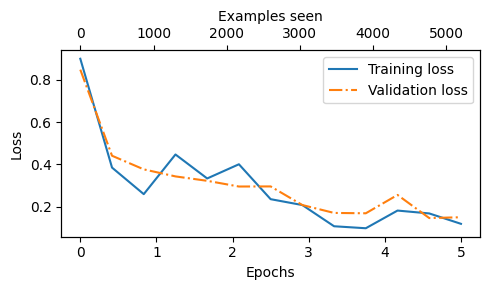

In [457]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

### Training vs. Validation Accuracy Curve

This plot visualizes how the classification accuracy of the GPT-2 Small model improves over training epochs on the SMS Spam detection task.

- **X-axis (bottom):** Epochs
- **X-axis (top):** Examples seen during training
- **Y-axis:** Accuracy (0 to 1.0)

| Metric           | Observation                                |
|------------------|---------------------------------------------|
| Training Accuracy | Increases steadily to 100% by final epoch |
| Validation Accuracy | Closely tracks training, reaches ~95%    |


> **Interpretation:** The model shows strong learning progress without signs of overfitting. The small gap between training and validation accuracy suggests effective generalization.


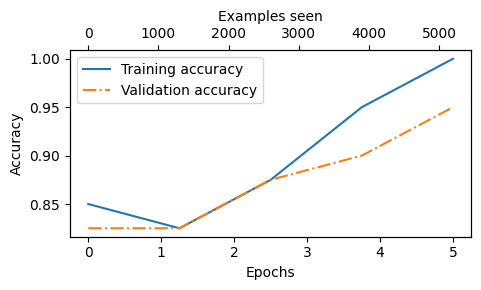

In [458]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))

plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy")

### Final Accuracy Evaluation (Full Dataset)

After completing fine-tuning of the GPT-2 Small classifier on the SMS Spam dataset, the model was evaluated on the **entire** training, validation, and test sets.

| Dataset    | Accuracy (%) |
|------------|--------------|
| Training   | **98.75%**   |
| Validation | **95.97%**   |
| Test       | **94.00%**   |

> **Conclusion:**  
The model demonstrates **strong generalization** across all sets. High training accuracy (98.75%) paired with competitive validation and test accuracies suggests that the classifier has **successfully learned to distinguish spam from ham messages** without overfitting.




In [459]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 98.75%
Validation accuracy: 95.97%
Test accuracy: 94.00%


USING THE LLM AS A SPAM CLASSIFIER

### SMS Spam Classification Utility

The `classify_review` function performs **inference** using a fine-tuned GPT model to classify a single text message as `"spam"` or `"not spam"`.

#### Function Breakdown:

| Step | Description |
|------|-------------|
| 1    | Tokenize input using GPT tokenizer |
| 2    | Truncate to `max_length` or model’s context limit |
| 3    | Pad input to ensure fixed length |
| 4    | Add batch dimension (batch size = 1) |
| 5    | Disable gradient computation for efficiency |
| 6    | Extract final token’s logits for classification |
| 7    | Return `"spam"` or `"not spam"` based on prediction |

> Make sure to pass `max_length=BASE_CONFIG["context_length"]` to prevent dimension mismatch.


In [460]:
def classify_review(text, model, tokenizer, device, max_length=None, pad_token_id=50256):
    model.eval()

    # Prepare inputs to the model
    # Step 1: Prepare inputs to the model
    input_ids = tokenizer.encode(text)
    supported_context_length = model.pos_emb.weight.shape[0]
    # Note: In the book, this was originally written as pos_emb.weight.shape[1] by mistake
    # It didn't break the code but would have caused unnecessary truncation (to 768 instead of 1024)

    # Step 2: Truncate sequences if they are too long
    input_ids = input_ids[:min(max_length, supported_context_length)]

    # Step 3: Pad sequences to match max_length
    input_ids += [pad_token_id] * (max_length - len(input_ids))

    # Step 4: Add batch dimension
    input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0) # add batch dimension

    # Model inference
    # Step 5: Model inference without gradient tracking
    with torch.no_grad():
        # Step 6: Use logits from the last output token
        logits = model(input_tensor)[:, -1, :]  # Logits of the last output token
    predicted_label = torch.argmax(logits, dim=-1).item()

    # Return the classified result
    return "spam" if predicted_label == 1 else "not spam"       # Step 7: Return the classified result

###Classify a Spam SMS using GPT Classifier


In [461]:
text_1 = (
    "You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award."
)

print(classify_review(
    text_1, model, tokenizer, device, max_length=train_dataset.max_length
))

spam


In [462]:
text_2 = (
    "Hey, just wanted to check if we're still on"
    " for dinner tonight? Let me know!"
)

print(classify_review(
    text_2, model, tokenizer, device, max_length=train_dataset.max_length
))

not spam


In [467]:
text_1 = (
    "Congratulations! You've been selected for a free cruise to the Bahamas. Call now to claim your prize."
)
print(classify_review(
    text_1, model, tokenizer, device, max_length=train_dataset.max_length
))

text_2 = (
    "URGENT! Your mobile number has won $5000. Click the link to claim: http://bit.ly/winprize"
)
print(classify_review(
    text_2, model, tokenizer, device, max_length=train_dataset.max_length
))

text_3 = (
    "Limited time offer: Buy 1 get 2 FREE! Visit our store today or call 123-456-7890."
)
print(classify_review(
    text_3, model, tokenizer, device, max_length=train_dataset.max_length
))


spam
spam
spam


In [468]:
text_4 = (
    "Don’t forget our meeting tomorrow at 10 AM. Let me know if the time works for you."
)
print(classify_review(
    text_4, model, tokenizer, device, max_length=train_dataset.max_length
))

text_5 = (
    "Just wanted to say happy birthday! Hope you have an amazing day ahead 🎉"
)
print(classify_review(
    text_5, model, tokenizer, device, max_length=train_dataset.max_length
))

text_6 = (
    "Can you send me the notes from today's lecture? I missed the class."
)
print(classify_review(
    text_6, model, tokenizer, device, max_length=train_dataset.max_length
))


not spam
not spam
not spam
